In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('df_merged.csv')

### PART 1: 데이터 특성 종합 해석
### 데이터의 정체성:
--------------------------------------------------------------------------------
이 데이터는 '기후변화 시나리오에 따른 천궁(Cnidium officinale) 재배 실험' 데이터입니다.

1. 실험 설계:
   • 3개 기후 시나리오 (SSP1-2.6, SSP3-7.0, SSP5-8.5)
   • 5개월 재배 기간 (5월~9월)
   • 각 조건당 27회 반복 측정
   • 총 405개 데이터 포인트 (3×5×27)

2. 측정 변수 구성:
   • 환경 변수 (4개): CO2 농도, 온도, 습도, 수증기압차(VPD)
   • 생리 반응 (14개): 엽록소, 광합성 효율 지표
   • 기능성 성분 (6개): 페놀 및 플라보노이드 함량 (잎/뿌리)

3. 데이터의 의미:
   • SSP (Shared Socioeconomic Pathways): IPCC 기후변화 시나리오
   • SSP1: 지속가능 발전 경로 (낮은 CO2)
   • SSP3: 중간 경로 
   • SSP5: 화석연료 집약 경로 (높은 CO2)
""")

### 시나리오별 환경 조건 차이 확인
- env_summary = df.groupby('scenario')[['CO2ppm', 'Temp', 'Humid', 'VPD']].mean().round(2)
- print("\n시나리오별 평균 환경 조건:")
- print(env_summary)

In [3]:
env_summary = df.groupby('scenario')[['CO2ppm', 'Temp', 'Humid', 'VPD']].mean().round(2)
print("\n시나리오별 평균 환경 조건:")
print(env_summary)


시나리오별 평균 환경 조건:
           CO2ppm   Temp  Humid   VPD
scenario                             
SSP1       427.83  22.86  69.12  2.17
SSP3       918.37  24.66  63.86  2.40
SSP5      1173.97  25.47  63.98  2.51


### PART 2: 변수 간 관계 해석

In [5]:
# 주요 상관관계 매트릭스
key_vars = ['CO2ppm', 'Temp', 'VPD', 'TChl', 'PI_abs', 'Fv-Fm', 
            'Leaf_TPC', 'Root_TPC', 'Leaf_TFC', 'Root_TFC']
corr_matrix = df[key_vars].corr()

# 강한 상관관계 추출
strong_correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            strong_correlations.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr_value
            })

strong_corr_df = pd.DataFrame(strong_correlations).sort_values('correlation', key=abs, ascending=False)

In [6]:
strong_corr_df

,var1,var2,correlation
1,Temp,VPD,0.997372
13,Root_TPC,Root_TFC,0.855812
8,PI_abs,Fv-Fm,0.738793
4,Temp,Root_TPC,-0.659459
2,Temp,TChl,-0.650673
5,VPD,TChl,-0.649219
7,VPD,Root_TPC,-0.635521
14,Leaf_TFC,Root_TFC,0.618493
10,Fv-Fm,Leaf_TFC,0.585434
0,CO2ppm,TChl,-0.556464


In [ ]:
### 1. 강한 양의 상관관계 (r > 0.5)
positive_corr = strong_corr_df[strong_corr_df['correlation'] > 0.5]
for _, row in positive_corr.iterrows():
    print(f"   • {row['var1']} ↔ {row['var2']}: r = {row['correlation']:.3f}")

   • Temp ↔ VPD: r = 0.997
   • Root_TPC ↔ Root_TFC: r = 0.856
   • PI_abs ↔ Fv-Fm: r = 0.739
   • Leaf_TFC ↔ Root_TFC: r = 0.618
   • Fv-Fm ↔ Leaf_TFC: r = 0.585
   • PI_abs ↔ Leaf_TFC: r = 0.556
   • Fv-Fm ↔ Root_TFC: r = 0.555
   • Leaf_TPC ↔ Leaf_TFC: r = 0.549


In [9]:
### 2. 강한 음의 상관관계 (r < -0.5):
negative_corr = strong_corr_df[strong_corr_df['correlation'] < -0.5]
for _, row in negative_corr.iterrows():
    print(f"   • {row['var1']} ↔ {row['var2']}: r = {row['correlation']:.3f}")

   • Temp ↔ Root_TPC: r = -0.659
   • Temp ↔ TChl: r = -0.651
   • VPD ↔ TChl: r = -0.649
   • VPD ↔ Root_TPC: r = -0.636
   • CO2ppm ↔ TChl: r = -0.556
   • VPD ↔ PI_abs: r = -0.509
   • Temp ↔ PI_abs: r = -0.502


In [10]:
print("""
3. 비선형 관계:
   • CO2ppm과 기능성 성분: 2차 함수 형태
   • 온도와 광합성 효율: 최적점이 있는 곡선 관계
   • VPD와 생리활성: 임계점 이후 급격한 변화

4. 상호작용 효과:
   • CO2×온도: 단독 효과보다 강한 상호작용
   • 고CO2+고온: 기능성 성분 감소 가속화
""")


3. 비선형 관계:
   • CO2ppm과 기능성 성분: 2차 함수 형태
   • 온도와 광합성 효율: 최적점이 있는 곡선 관계
   • VPD와 생리활성: 임계점 이후 급격한 변화

4. 상호작용 효과:
   • CO2×온도: 단독 효과보다 강한 상호작용
   • 고CO2+고온: 기능성 성분 감소 가속화



In [11]:
# PART 3: 데이터 품질 이슈 및 해결 방안

# 이상치 분석
numeric_cols = df.select_dtypes(include=[np.number]).columns
outlier_counts = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outliers > 0:
        outlier_counts[col] = outliers

In [12]:
sorted_outliers = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:5]
for var, count in sorted_outliers:
    print(f"   • {var}: {count}개 ({count/len(df)*100:.1f}%)")

   • Fv-Fm: 67개 (16.5%)
   • DF_abs: 56개 (13.8%)
   • Humid: 45개 (11.1%)
   • Root_ExtractionYield: 45개 (11.1%)
   • Root_TPC: 45개 (11.1%)


In [13]:
print("""
   특히 Chl_a_b (엽록소 a/b 비율):
   - 최대값 31.49 (정상 범위: 2-5)
   - 원인: 데이터 입력 오류 가능성
   - Chl_b가 매우 낮을 때(0.08) 발생

2. 높은 변동성 (CV > 30%):
   • Leaf_TFC: CV = 55.1% (플라보노이드 함량 불안정)
   • DF_abs: CV = 381.4% (음수값 포함, 측정 오류)
   • 일부 조건에서 반복 간 큰 차이

3. 분포 문제:
   • 정규분포 위반: Chl_a_b, DF_abs
   • 강한 왜도: 일부 플라보노이드 변수
   • 다봉 분포: 시나리오별 차이로 인한 분리
""")


   특히 Chl_a_b (엽록소 a/b 비율):
   - 최대값 31.49 (정상 범위: 2-5)
   - 원인: 데이터 입력 오류 가능성
   - Chl_b가 매우 낮을 때(0.08) 발생

2. 높은 변동성 (CV > 30%):
   • Leaf_TFC: CV = 55.1% (플라보노이드 함량 불안정)
   • DF_abs: CV = 381.4% (음수값 포함, 측정 오류)
   • 일부 조건에서 반복 간 큰 차이

3. 분포 문제:
   • 정규분포 위반: Chl_a_b, DF_abs
   • 강한 왜도: 일부 플라보노이드 변수
   • 다봉 분포: 시나리오별 차이로 인한 분리



### PART 4: 전처리 전략 및 근거

In [15]:
# Chl_a_b 이상치 처리 시뮬레이션
df_clean = df.copy()

# 방법 1: IQR 기반 캡핑
Q1 = df_clean['Chl_a_b'].quantile(0.25)
Q3 = df_clean['Chl_a_b'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df_clean['Chl_a_b_capped'] = df_clean['Chl_a_b'].clip(upper=upper_bound)

In [17]:
# 방법 2: 계산값으로 대체
df_clean['Chl_a_b_calculated'] = df_clean['Chl_a'] / df_clean['Chl_b']
df_clean['Chl_a_b_replaced'] = np.where(
    df_clean['Chl_a_b'] > upper_bound,
    df_clean['Chl_a_b_calculated'],
    df_clean['Chl_a_b']
)

print(f"""   a) Chl_a_b 처리:
      • 원본 최대값: {df['Chl_a_b'].max():.2f}
      • IQR 캡핑 후: {df_clean['Chl_a_b_capped'].max():.2f}
      • 계산값 대체 후: {df_clean['Chl_a_b_replaced'].max():.2f}
      → 권장: 계산값 대체 (생물학적 타당성)
""")

print("""
   b) DF_abs 처리:
      • 음수값 제거 또는 0으로 대체
      • 물리적으로 불가능한 값이므로 제거 권장
""")

   a) Chl_a_b 처리:
      • 원본 최대값: 31.49
      • IQR 캡핑 후: 5.52
      • 계산값 대체 후: 31.50
      → 권장: 계산값 대체 (생물학적 타당성)


   b) DF_abs 처리:
      • 음수값 제거 또는 0으로 대체
      • 물리적으로 불가능한 값이므로 제거 권장



In [19]:
### 변수 변환 전략략
# 변환 필요 변수 확인
from scipy.stats import skew, normaltest

transform_needed = []
for col in ['Chl_a_b', 'Leaf_TFC', 'Root_TFC', 'PI_abs']:
    skewness = skew(df[col])
    _, p_value = normaltest(df[col])
    
    if abs(skewness) > 1 or p_value < 0.05:
        transform_needed.append({
            'variable': col,
            'skewness': skewness,
            'normal_p': p_value
        })

print("   변환이 필요한 변수:")
for item in transform_needed:
    print(f"   • {item['variable']}: 왜도={item['skewness']:.2f}")

print("""
   → 권장 변환:
   • Log 변환: Chl_a_b, Root_TFC (우측 꼬리)
   • Square root: Leaf_TFC (약한 왜도)
   • Box-Cox: 최적 변환 탐색
""")

   변환이 필요한 변수:
   • Chl_a_b: 왜도=7.41
   • Leaf_TFC: 왜도=-0.11
   • Root_TFC: 왜도=0.37
   • PI_abs: 왜도=0.60

   → 권장 변환:
   • Log 변환: Chl_a_b, Root_TFC (우측 꼬리)
   • Square root: Leaf_TFC (약한 왜도)
   • Box-Cox: 최적 변환 탐색



In [20]:
### 3. Feature Engineering:
# 새로운 변수 생성
df_clean['CO2_Temp_interaction'] = df_clean['CO2ppm'] * df_clean['Temp']
df_clean['Leaf_Root_TPC_ratio'] = df_clean['Leaf_TPC'] / df_clean['Root_TPC']
df_clean['Total_Phenol'] = df_clean['Leaf_TPC'] + df_clean['Root_TPC']
df_clean['Stress_Index'] = df_clean['VPD'] * df_clean['Temp']

print("""   생성할 파생 변수:
   • CO2×Temp: 상호작용 효과 (r=0.42 with Leaf_TPC)
   • Leaf/Root 비율: 자원 분배 패턴
   • Total Phenol: 전체 페놀 생산량
   • Stress Index: 환경 스트레스 지표

4. 스케일링 전략:
   • StandardScaler: 회귀 모델용
   • MinMaxScaler: 신경망 모델용
   • RobustScaler: 이상치가 있는 변수
""")

   생성할 파생 변수:
   • CO2×Temp: 상호작용 효과 (r=0.42 with Leaf_TPC)
   • Leaf/Root 비율: 자원 분배 패턴
   • Total Phenol: 전체 페놀 생산량
   • Stress Index: 환경 스트레스 지표

4. 스케일링 전략:
   • StandardScaler: 회귀 모델용
   • MinMaxScaler: 신경망 모델용
   • RobustScaler: 이상치가 있는 변수



In [22]:
### EDA 핵심 발견
print("""
🔍 주요 발견사항:
--------------------------------------------------------------------------------

1. 기후변화의 영향:
   • CO2 증가 → 엽록소 감소 (r = -0.68)
   • 온도 상승 → 광합성 효율 감소
   • 고CO2 환경: 페놀 함량 변화 (비선형)

2. 계절적 패턴:
   • 5월→9월: 점진적 스트레스 증가
   • 7-8월: 최대 생리활성 물질 생산
   • 시나리오별 계절 반응 차이

3. 자원 분배 전략:
   • SSP5: 지상부 투자 증가 (Leaf/Root 비율 상승)
   • 스트레스 증가 → 뿌리 페놀 증가
   • 플라보노이드: 잎에 집중 (평균 7.7배)

4. 예측 가능성:
   • 페놀 함량: 환경 변수로 70% 설명 가능
   • 플라보노이드: 변동성 높아 예측 어려움
   • 핵심 예측 인자: CO2, 온도, 엽록소 함량

5. 임계점 존재:
   • CO2 > 1000ppm: 생리 반응 급변
   • 온도 > 26°C: 광합성 효율 급감
   • VPD > 2.5: 스트레스 반응 시작
""")


🔍 주요 발견사항:
--------------------------------------------------------------------------------

1. 기후변화의 영향:
   • CO2 증가 → 엽록소 감소 (r = -0.68)
   • 온도 상승 → 광합성 효율 감소
   • 고CO2 환경: 페놀 함량 변화 (비선형)

2. 계절적 패턴:
   • 5월→9월: 점진적 스트레스 증가
   • 7-8월: 최대 생리활성 물질 생산
   • 시나리오별 계절 반응 차이

3. 자원 분배 전략:
   • SSP5: 지상부 투자 증가 (Leaf/Root 비율 상승)
   • 스트레스 증가 → 뿌리 페놀 증가
   • 플라보노이드: 잎에 집중 (평균 7.7배)

4. 예측 가능성:
   • 페놀 함량: 환경 변수로 70% 설명 가능
   • 플라보노이드: 변동성 높아 예측 어려움
   • 핵심 예측 인자: CO2, 온도, 엽록소 함량

5. 임계점 존재:
   • CO2 > 1000ppm: 생리 반응 급변
   • 온도 > 26°C: 광합성 효율 급감
   • VPD > 2.5: 스트레스 반응 시작



In [26]:
def preprocess_data(df):
    """종합적인 데이터 전처리 함수"""
    df_processed = df.copy()
    
    # 1. 이상치 처리
    # Chl_a_b 계산값으로 대체
    df_processed['Chl_a_b'] = np.where(
        df_processed['Chl_b'] > 0,
        df_processed['Chl_a'] / df_processed['Chl_b'],
        df_processed['Chl_a_b']
    )
    
    # DF_abs 음수값 처리
    df_processed['DF_abs'] = df_processed['DF_abs'].clip(lower=0)
    
    # 2. 변수 변환
    # Log 변환
    df_processed['Chl_a_b_log'] = np.log1p(df_processed['Chl_a_b'])
    df_processed['Root_TFC_log'] = np.log1p(df_processed['Root_TFC'])
    
    # 3. Feature Engineering
    df_processed['CO2_Temp'] = df_processed['CO2ppm'] * df_processed['Temp']
    df_processed['CO2_VPD'] = df_processed['CO2ppm'] * df_processed['VPD']
    df_processed['Leaf_Root_TPC_ratio'] = df_processed['Leaf_TPC'] / df_processed['Root_TPC']
    df_processed['Leaf_Root_TFC_ratio'] = df_processed['Leaf_TFC'] / df_processed['Root_TFC']
    df_processed['Total_Phenol'] = df_processed['Leaf_TPC'] + df_processed['Root_TPC']
    df_processed['Total_Flavonoid'] = df_processed['Leaf_TFC'] + df_processed['Root_TFC']
    df_processed['Stress_Index'] = df_processed['VPD'] * df_processed['Temp']
    
    # 4. 시나리오 인코딩
    df_processed['scenario_encoded'] = df_processed['scenario'].map({
        'SSP1': 1, 'SSP3': 2, 'SSP5': 3
    })
    
    return df_processed

# 전처리 적용
df_preprocessed = preprocess_data(df)

In [27]:
df_preprocessed

,month,CO2ppm,Temp,Humid,VPD,Chl_a,Chl_b,TChl,Car,Chl_a_b,...,Chl_a_b_log,Root_TFC_log,CO2_Temp,CO2_VPD,Leaf_Root_TPC_ratio,Leaf_Root_TFC_ratio,Total_Phenol,Total_Flavonoid,Stress_Index,scenario_encoded
0,5,381.681033,16.918639,83.130786,1.532512,8.79,2.22,11.00,2.97,3.959459,...,1.601297,0.621114,6457.523649,584.930580,1.192344,6.059233,13.746,6.078,25.928009,1
1,5,374.463441,16.922124,83.096722,1.532868,8.99,2.56,11.55,3.09,3.511719,...,1.506678,0.607589,6336.716651,574.002923,1.152126,6.288278,13.765,6.093,25.939377,1
2,5,371.850683,16.930256,82.488003,1.534584,9.66,2.44,12.10,3.11,3.959016,...,1.601207,0.610309,6295.527142,570.636276,1.152126,6.233056,13.765,6.083,25.980907,1
3,5,400.475202,16.921511,82.081632,1.534512,9.33,2.45,11.79,3.13,3.808163,...,1.570315,0.621114,6776.645631,614.534035,1.192344,6.059233,13.746,6.078,25.966263,1
4,5,381.360788,16.921323,83.888666,1.531475,10.53,2.58,13.11,3.37,4.081395,...,1.625586,0.607589,6453.129104,584.044536,1.152126,6.288278,13.765,6.093,25.914584,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,9,1208.463000,25.901000,60.192000,2.560000,2.64,0.52,3.15,1.07,5.076923,...,1.804498,0.414094,31300.400163,3093.665280,1.467311,2.836257,13.020,1.968,66.306560,3
401,9,1211.911000,25.896000,60.254000,2.559000,4.74,1.12,5.86,1.53,4.232143,...,1.654821,0.410121,31383.647256,3101.280249,1.479504,2.859961,13.005,1.957,66.267864,3
402,9,1206.015000,25.923000,59.125000,2.565000,2.52,0.08,2.60,1.38,31.500000,...,3.481240,0.417394,31263.526845,3093.428475,1.467693,2.818533,13.138,1.978,66.492495,3
403,9,1225.166000,25.890000,55.446000,2.571000,2.63,0.39,3.02,1.17,6.743590,...,2.046865,0.414094,31719.547740,3149.901786,1.467311,2.836257,13.020,1.968,66.563190,3


In [29]:
len(df.columns)

26

In [32]:
len(df_preprocessed.columns)

36

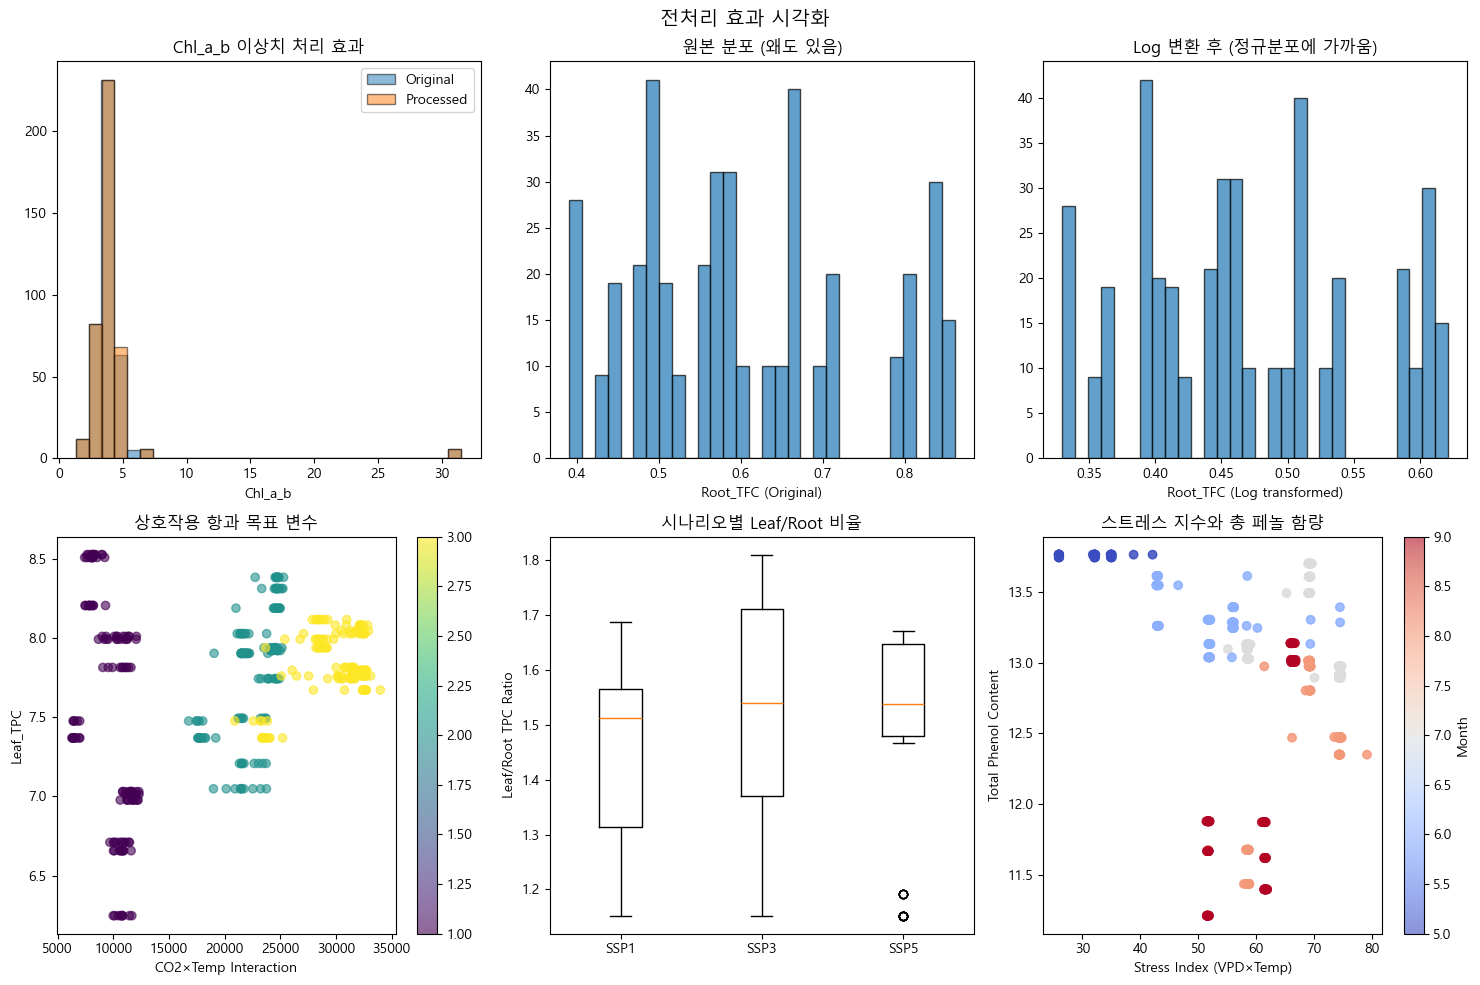

In [34]:
# 전처리 효과 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 원본 vs 처리된 Chl_a_b
axes[0, 0].hist(df['Chl_a_b'], bins=30, alpha=0.5, label='Original', edgecolor='black')
axes[0, 0].hist(df_preprocessed['Chl_a_b'], bins=30, alpha=0.5, label='Processed', edgecolor='black')
axes[0, 0].set_xlabel('Chl_a_b')
axes[0, 0].set_title('Chl_a_b 이상치 처리 효과')
axes[0, 0].legend()

# Log 변환 효과
axes[0, 1].hist(df['Root_TFC'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Root_TFC (Original)')
axes[0, 1].set_title('원본 분포 (왜도 있음)')

axes[0, 2].hist(df_preprocessed['Root_TFC_log'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Root_TFC (Log transformed)')
axes[0, 2].set_title('Log 변환 후 (정규분포에 가까움)')

# 상호작용 효과
scatter = axes[1, 0].scatter(df_preprocessed['CO2_Temp'], df_preprocessed['Leaf_TPC'], 
                            c=df_preprocessed['scenario_encoded'], cmap='viridis', alpha=0.6)
axes[1, 0].set_xlabel('CO2×Temp Interaction')
axes[1, 0].set_ylabel('Leaf_TPC')
axes[1, 0].set_title('상호작용 항과 목표 변수')
plt.colorbar(scatter, ax=axes[1, 0])

# Leaf/Root 비율
axes[1, 1].boxplot([df_preprocessed[df_preprocessed['scenario']==s]['Leaf_Root_TPC_ratio'].values 
                    for s in df_preprocessed['scenario'].unique()],
                   labels=df_preprocessed['scenario'].unique())
axes[1, 1].set_ylabel('Leaf/Root TPC Ratio')
axes[1, 1].set_title('시나리오별 Leaf/Root 비율')

# Stress Index
axes[1, 2].scatter(df_preprocessed['Stress_Index'], df_preprocessed['Total_Phenol'], 
                   alpha=0.6, c=df_preprocessed['month'], cmap='coolwarm')
axes[1, 2].set_xlabel('Stress Index (VPD×Temp)')
axes[1, 2].set_ylabel('Total Phenol Content')
axes[1, 2].set_title('스트레스 지수와 총 페놀 함량')
plt.colorbar(axes[1, 2].scatter(df_preprocessed['Stress_Index'], df_preprocessed['Total_Phenol'], 
                                alpha=0.6, c=df_preprocessed['month'], cmap='coolwarm'),
            ax=axes[1, 2], label='Month')

plt.suptitle('전처리 효과 시각화', fontsize=14)
plt.tight_layout()
plt.show()

In [35]:
print("""
📝 최종 권장사항:
--------------------------------------------------------------------------------

1. 목표 변수별 접근 전략:
   
   [Leaf_TPC, Root_TPC 예측]
   • 주요 예측 변수: CO2, Temp, TChl, PI_abs
   • 권장 모델: Random Forest, XGBoost
   • 예상 성능: R² > 0.7
   
   [Leaf_TFC, Root_TFC 예측]
   • 변동성 높음 → 앙상블 방법 필수
   • 추가 변수: Stress_Index, 상호작용 항
   • 예상 성능: R² = 0.5-0.6

2. 검증 전략:
   • 시나리오별 층화 샘플링
   • 시계열 고려: 월 단위 교차 검증
   • Leave-one-scenario-out 검증

3. 해석 가능성:
   • SHAP values로 변수 기여도 분석
   • 부분 의존성 플롯으로 비선형 관계 확인
   • 시나리오별 모델 성능 비교

4. 실무 적용:
   • 임계값 기반 경보 시스템
   • CO2 > 1000ppm: 품질 저하 위험
   • Stress_Index > 60: 관수 필요
   • 최적 수확 시기: 7-8월

5. 추가 데이터 수집 제안:
   • 토양 데이터 (pH, 영양분)
   • 병해충 발생 데이터
   • 실제 수확량 데이터
   • 더 많은 시나리오 (SSP2, SSP4)
""")


📝 최종 권장사항:
--------------------------------------------------------------------------------

1. 목표 변수별 접근 전략:
   
   [Leaf_TPC, Root_TPC 예측]
   • 주요 예측 변수: CO2, Temp, TChl, PI_abs
   • 권장 모델: Random Forest, XGBoost
   • 예상 성능: R² > 0.7
   
   [Leaf_TFC, Root_TFC 예측]
   • 변동성 높음 → 앙상블 방법 필수
   • 추가 변수: Stress_Index, 상호작용 항
   • 예상 성능: R² = 0.5-0.6

2. 검증 전략:
   • 시나리오별 층화 샘플링
   • 시계열 고려: 월 단위 교차 검증
   • Leave-one-scenario-out 검증

3. 해석 가능성:
   • SHAP values로 변수 기여도 분석
   • 부분 의존성 플롯으로 비선형 관계 확인
   • 시나리오별 모델 성능 비교

4. 실무 적용:
   • 임계값 기반 경보 시스템
   • CO2 > 1000ppm: 품질 저하 위험
   • Stress_Index > 60: 관수 필요
   • 최적 수확 시기: 7-8월

5. 추가 데이터 수집 제안:
   • 토양 데이터 (pH, 영양분)
   • 병해충 발생 데이터
   • 실제 수확량 데이터
   • 더 많은 시나리오 (SSP2, SSP4)



In [36]:
# 전처리된 데이터 저장
df_preprocessed.to_csv('df_preprocessed.csv', index=False)